In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1337)

In [2]:
def target_dist(x):
    '''
    Using e^x as the target dist again, but need to wrap it in log instead of just returning x
    Returns log p(x) = log prob of state x occuring under p
    '''
    return torch.log(torch.exp(x)) # Using e^x as the target dist, so log prob will just be x

def propose(x, sigma):
    '''
    y = x + (sigma^2 / 2) * grad(log(p(x))) + N(0, sigma^2 I)
    Returns y = new state using the MALA proposal mechanism
    '''
    x.requires_grad_()
    epsilon = sigma ** 2
    grad_prob_x = torch.autograd.grad(target_dist(x), x, create_graph=True)[0]
    y = x + 0.5 * epsilon * grad_prob_x + torch.tensor(sigma) * torch.randn_like(x)
    return y.detach()

def proposal_dist(y, x, sigma):
    '''
    Computes the log of the proposal distribution q(y|x) for MALA, where
    q(y|x) is proportional to exp(-(|y - x - (sigma^2 / 2) * grad(log(p(x)))|^2 / (2*sigma))^2).
    Returns log q(y|x) = log prob of state y occuring under q, given x
    '''
    x.requires_grad_()
    epsilon = sigma ** 2  
    grad_prob_x = torch.autograd.grad(target_dist(x), x, create_graph=True)[0]
    
    squared_diff = y - x - 0.5 * epsilon * grad_prob_x
    
    return -(torch.abs(squared_diff / (2 * epsilon)) ** 2)

def accept_probability(y, x, sigma):
    '''
    Need to exponentiate the ratio since using log probs
    Returns A = the acceptance prob. based on proposed state, y, and current state, x
    '''
    log_ratio = target_dist(y) + proposal_dist(x, y, sigma) - (target_dist(x) + proposal_dist(y, x, sigma))
    A = torch.min(
        torch.tensor(1.0),
        torch.exp(log_ratio)     
    )
    return A

def mala(num_iters, sigma):
    samples = []
    x = torch.zeros(1) # initial state doesn't matter, can be anything
    
    for i in range(1, num_iters):
        y = propose(x, sigma) # proposed state, y, given current state, x
        A = accept_probability(y, x, sigma)
        
        if torch.rand(1) < A:
            x = y # accept move x->y with prob. min(1, A), else keep x the same
        
        samples.append(x)
    
    return np.array([s.item() for s in samples])

In [3]:
def view(samples, title):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # histogram
    axs[0].hist(samples, bins=100, density=True, alpha=0.75, edgecolor='black')
    axs[0].set_title(f'Histogram of samples from $e^x$ for {title}')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('Density')

    # trace plot
    axs[1].plot(samples, marker='o', linestyle='', markersize=2)
    axs[1].set_title(f'Trace plot of the samples for {title}')
    axs[1].set_xlabel('Sample index')
    axs[1].set_ylabel('Sample value')

    plt.tight_layout()
    plt.show()

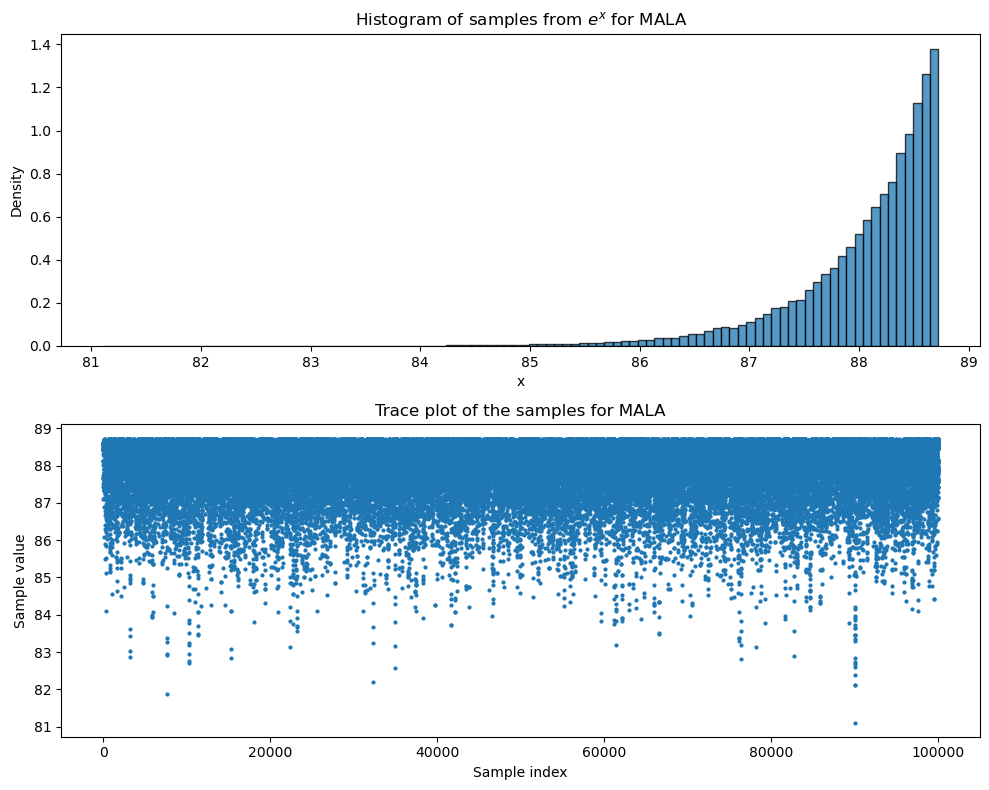

In [4]:
num_iters = 100000
burnin = 10000 # burn-in values to discard
sigma = 1.0

samples = mala(num_iters + burnin, sigma)
view(samples[burnin:], 'MALA')